
# POS Tagging with CNN 

**Author:** Alkistis Lemonaki  
**Goal:** Implement CNN for Part-of-Speech (POS) tagging and compare it with different neural network architectures.  
**Dataset:** Universal Dependencies — English EWT (`en_ewt`).  
**Highlights:** CNN model · Evaluation with Accuracy & F1-score · Analysis of sequence tagging performance.


In [ ]:

# --- Configuration & imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score

# Render options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# Base directory (if you want to store models/data)
BASE_DIR = os.environ.get("POS_TAGGING_DIR", "data")

def p(*parts):
    "Helper to safely join paths"
    return os.path.join(*parts)


In [ ]:
#pip install tensorflow numpy sklearn
#!pip install gensim

In [ ]:

# !pip install --upgrade --no-cache-dir numpy pandas datasets conllu

In [ ]:
# !pip install -U numpy datasets --force-reinstall --no-cache-dir

In [ ]:
!pip install datasets
!pip install conllu
!pip install --upgrade datasets

In [ ]:
#!rm -rf ~/.cache/huggingface/datasets
#!rm -rf /root/.cache/huggingface/datasets
#!rm -rf /content/.cache/huggingface/datasets

In [ ]:
!nvidia-smi

Mon Jun  9 15:43:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load the data

In [ ]:
import numpy as np
from collections import defaultdict, Counter
from datasets import load_dataset

In [ ]:
dataset = load_dataset("universal_dependencies", "en_ewt")

train_data = dataset["train"]
dev_data = dataset["validation"]
test_data = dataset["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/191k [00:00<?, ?B/s]

universal_dependencies.py:   0%|          | 0.00/87.8k [00:00<?, ?B/s]

The repository for universal_dependencies contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/universal_dependencies.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


Generating train split:   0%|          | 0/12543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2077 [00:00<?, ? examples/s]

In [ ]:
train_data

Dataset({
    features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
    num_rows: 12543
})

## Preprocess data for CNN Input

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

In [ ]:
def extract_sequences(dataset):
    sequences = []
    for item in dataset:
        tokens = item['tokens']
        tags = item['upos']
        sequences.append((tokens, tags))
    return sequences

In [ ]:
train_seqs = extract_sequences(train_data)
dev_seqs = extract_sequences(dev_data)
test_seqs = extract_sequences(test_data)

In [ ]:
# Build word2idx and tag2idx using only training data - Assigns IDs to all words/tags in training data
word2idx = defaultdict(lambda: len(word2idx))
tag2idx = defaultdict(lambda: len(tag2idx))

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
word2idx[PAD_TOKEN]
word2idx[UNK_TOKEN]

for tokens, tags in train_seqs:
    for token in tokens:
        _ = word2idx[token.lower()]
    for tag in tags:
        _ = tag2idx[tag]

In [ ]:
# Finalize dictionaries (default only for words)
# if word is not seen, returns the index of the UNK
word2idx = defaultdict(lambda: word2idx[UNK_TOKEN], word2idx)
# transofrming from default dict to dict to make sure that no more tags are accidentally added to the dict
tag2idx = dict(tag2idx)

In [ ]:
# used to decode predicted tag indices back into readable tag labels

# The official list of tag names, in index order
upos_names = dataset["train"].features["upos"].feature.names  # index → tag name

# Your current tag2idx maps: dataset tag ID → model ID
# We want the reverse: model ID → tag name
idx2tag = {model_id: upos_names[dataset_id] for dataset_id, model_id in tag2idx.items()}
idx2tag

{0: 'PROPN',
 1: 'PUNCT',
 2: 'ADJ',
 3: 'NOUN',
 4: 'VERB',
 5: 'DET',
 6: 'ADP',
 7: 'AUX',
 8: 'PRON',
 9: 'PART',
 10: 'SCONJ',
 11: 'NUM',
 12: 'ADV',
 13: 'CCONJ',
 14: '_',
 15: 'X',
 16: 'INTJ',
 17: 'SYM'}

In [ ]:
# convert tokens/tags into lists of integers
def encode_sequences(sequences, word2idx, tag2idx):
    X = []
    y = []
    for tokens, tags in sequences:
        x_seq = [word2idx[token.lower()] for token in tokens]
        y_seq = [tag2idx[tag] for tag in tags]
        X.append(torch.tensor(x_seq, dtype=torch.long))
        y.append(torch.tensor(y_seq, dtype=torch.long))
    return X, y

In [ ]:
X_train, y_train = encode_sequences(train_seqs, word2idx, tag2idx)
X_dev, y_dev = encode_sequences(dev_seqs, word2idx, tag2idx)
X_test, y_test = encode_sequences(test_seqs, word2idx, tag2idx)

In [ ]:
# first sentence encoded in integers based on the word2idx dictionary
X_train[1]

tensor([25, 26, 27, 19, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 24, 40])

## Pad and Batch the Data

In [ ]:
def collate_batch(batch):
    # Split batch into inputs (X) and targets (y)
    X_batch, y_batch = zip(*batch)

    # Record the original lengths before padding
    lengths = [len(seq) for seq in X_batch]

    # Pad the input sequences with word2idx["<PAD>"]
    X_batch = pad_sequence(X_batch, batch_first=True, padding_value=word2idx["<PAD>"])

    # Pad the tag sequences with -100 (special value to ignore in loss)
    y_batch = pad_sequence(y_batch, batch_first=True, padding_value=-100)

    return X_batch, y_batch, lengths

In [ ]:
from torch.utils.data import DataLoader

# Combine input and output sequences into tuples
train_dataset = list(zip(X_train, y_train))
dev_dataset = list(zip(X_dev, y_dev))
test_dataset = list(zip(X_test, y_test))

# Create DataLoaders with our custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)


In [ ]:
# Get one batch from the DataLoader
X_batch, y_batch, lengths = next(iter(train_loader))

In [ ]:
# Choose a sample index within the batch to inspect
i = 0 #choose a number in the batch to see the original length, the maximum length(of the batch) and how it is padded

print("Original length:", lengths[i])
print("Maximum length:", max(lengths))
print("Input IDs (padded):", X_batch[i])
print("Target tags (padded):", y_batch[i])

Original length: 16
Maximum length: 58
Input IDs (padded): tensor([   96,  1658,   538,   713, 10437,  1004,  6596,  5525,   104,   544,
          371,   120,  2493, 16909, 16910,    24,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])
Target tags (padded): tensor([   8,    4,    4,    2,    3,    1,    3,    3,   13,   14,    7,    9,
           4,   12,    2,    1, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100])


## Dataset Statistics

In [ ]:
print(f'Vocabulary size: {len(word2idx)}')

Vocabulary size: 19805


In [ ]:
num_train_sent = len(train_seqs)
num_val_sent = len(dev_seqs)
num_test_sent = len(test_seqs)
print(f'training sequences length: {num_train_sent}')
print(f'development sequences length: {num_val_sent}')
print(f'test sequences length: {num_test_sent}')

training sequences length: 12543
development sequences length: 2002
test sequences length: 2077


In [ ]:
def total_token_count(sequences):
    return sum(len(tokens) for tokens, _ in sequences)

train_token_count = total_token_count(train_seqs)
val_token_count = total_token_count(dev_seqs)
test_token_count = total_token_count(test_seqs)

print(f'training tokens count: {train_token_count}')
print(f'development tokens count: {val_token_count}')
print(f'test tokens count: {test_token_count}')

training tokens count: 207053
development tokens count: 25478
test tokens count: 25429


In [ ]:
def average_sentence_length(sequences):
    return sum(len(tokens) for tokens, _ in sequences) / len(sequences)

avg_train_length = average_sentence_length(train_seqs)
avg_val_length = average_sentence_length(dev_seqs)
avg_test_length = average_sentence_length(test_seqs)

print(f'average training sentence length: {avg_train_length:.2f}')
print(f'average development sentence length: {avg_val_length:.2f}')
print(f'average test sentence length: {avg_test_length:.2f}')

average training sentence length: 16.51
average development sentence length: 12.73
average test sentence length: 12.24


In [ ]:
def get_unique_tags(sequences):
    tag_set = set()
    for _, tags in sequences:
        tag_set.update(tags)
    return tag_set

pos_tags = get_unique_tags(train_seqs)
num_tags = len(pos_tags)
int2tag = train_data.features["upos"].feature.int2str

print(f'unique POS tags: {int2tag(pos_tags)}')
print(f'number of tags: {num_tags}')

unique POS tags: ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'PROPN', 'PRON', 'X', '_', 'ADV', 'INTJ', 'VERB', 'AUX']
number of tags: 18


#### Top 5 most frequent tags

In [ ]:
def get_tag_freqs(sequences):
    counter = Counter()
    for _, tag_ids in sequences:
        counter.update(tag_ids)
    return counter

tag_freqs = get_tag_freqs(train_seqs)
for tag_id, count in tag_freqs.most_common(5):
    print(f"{int2tag(tag_id)}: {count}")

NOUN: 34786
PUNCT: 23676
VERB: 23028
PRON: 18584
ADP: 17625


## Download GloVe (pre-trained embeddings)

In [ ]:
import requests, zipfile, io

url = "https://nlp.stanford.edu/data/glove.6B.zip"
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extract("glove.6B.100d.txt", path=".")

In [ ]:
def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    # Initialize random embeddings
    embeddings = np.random.uniform(-0.05, 0.05, (len(word2idx), embedding_dim)).astype(np.float32)
    embeddings[word2idx["<PAD>"]] = np.zeros(embedding_dim)
    # embeddings[word2idx["<UNK>"]] = np.random.uniform(-0.05, 0.05, embedding_dim).astype(np.float32) # Initialize <UNK> randomly

    # Load GloVe into a dict
    glove_dict = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype=np.float32)
            glove_dict[word] = vector

    # Compute the centroid of all glove vectors
    all_vectors = np.stack(list(glove_dict.values()))
    glove_centroid = np.mean(all_vectors, axis=0)

    # Assign <UNK> to the centroid (most neutral)
    embeddings[word2idx["<UNK>"]] = glove_centroid

    # Fill in known words
    found = 0
    for word, idx in word2idx.items():
        if word in glove_dict:
            embeddings[idx] = glove_dict[word]
            found += 1

    print(f"Matched {found} / {len(word2idx)} words from your vocab ({found / len(word2idx):.2%})")
    return embeddings


In [ ]:
glove_path = "glove.6B.100d.txt"  # Download from https://nlp.stanford.edu/projects/glove/
embedding_matrix = load_glove_embeddings(glove_path, word2idx, embedding_dim=100)

Matched 17091 / 19805 words from your vocab (86.30%)


In [ ]:
embedding_matrix.shape

(19805, 100)

## CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
class POSCNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim,
                 embedding_matrix=None, pad_idx=0, filter_sizes=(2, 3, 4),
                 num_filters=128, num_stacked_layers=2,
                 dropout_rate=0.3, freeze_embeddings=True):
        super(POSCNNModel, self).__init__()

        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = not freeze_embeddings

        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = torch.nn.ReLU()

        # First convolutional layer
        self.conv_blocks = nn.ModuleList([ nn.Conv1d(in_channels=embed_dim,
                      out_channels=num_filters, kernel_size=f, padding=f // 2)
                      for f in filter_sizes ])

        # Stacked convolutional blocks with residuals
        self.stacked_convs = nn.ModuleList()
        for _ in range(num_stacked_layers):
            conv = nn.Conv1d(in_channels=num_filters * len(filter_sizes),
                     out_channels=num_filters * len(filter_sizes),
                     kernel_size=3, padding=1)
            self.stacked_convs.append(conv)

        # Output layer: predicts a tag for each token
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)

    def forward(self, x):
      """
      x: (batch_size, seq_len) - word indices
      """
      orig_seq_len = x.size(1)  # Save original sequence length
      embedded = self.dropout(self.embedding(x))  # (batch, seq_len, embed_dim)
      x = embedded.transpose(1, 2)  # (batch, embed_dim, seq_len)

      # N-gram convolutional blocks
      conv_outputs = [self.relu(conv(x)) for conv in self.conv_blocks]
      # Get max sequence length after convolution
      max_seq_len = max([o.size(2) for o in conv_outputs])

      # Pad each output to the max length
      padded_outputs = [F.pad(o, (0, max_seq_len - o.size(2))) for o in conv_outputs]
      x = torch.cat(padded_outputs, dim=1)  # (batch, num_filters * len(filter_sizes), seq_len)

      # Stacked residual convolutions
      for conv in self.stacked_convs:
          residual = x
          x = self.relu(conv(x))
          if x.shape == residual.shape:
              x = self.dropout(x + residual)
          else:
              x = self.dropout(x)

      x = x.transpose(1, 2)  # (batch, seq_len, features)
      # Crop back to original input length for alignment with y
      x = x[:, :orig_seq_len, :]
      logits = self.fc(x)    # (batch, seq_len, output_dim)

      return logits


CNN's modeled with parallel n-gram filters, that extract local patterns

## Train Model

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, print_every=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_path = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch, lengths in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Reset gradients before the next batch
            optimizer.zero_grad()
            logits = model(X_batch)  # (batch_size, seq_len, output_dim)

            # Reshape for loss: flatten batch and time dimensions
            loss = criterion(logits.view(-1, logits.shape[-1]), y_batch.view(-1))
            # computes gradients
            loss.backward()
            # updates model weights
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # -------- Validation --------
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch, lengths in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                logits = model(X_batch)
                loss = criterion(logits.view(-1, logits.shape[-1]), y_batch.view(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % print_every == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

         # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            if best_model_path is not None and os.path.exists(best_model_path):
                os.remove(best_model_path)

            best_model_path = f"Model_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), best_model_path)

    print(f"\nBest model saved as: {best_model_path}")

    return train_losses, val_losses, best_model_path

In [ ]:
from itertools import product

param_grid = {
    'num_stacked_layers': [1, 2],
    'dropout_rate': [0.3, 0.5],
    'num_filters': [64, 128],
    'filter_sizes': [(2, 3, 4), (3, 4, 5)],

}

# Convert to list of hyperparameter combinations
param_combinations = list(product(
    param_grid['num_stacked_layers'],
    param_grid['dropout_rate'],
    param_grid['num_filters'],
    param_grid['filter_sizes'],
))

In [ ]:
best_f1 = 0.0
best_config = None
best_model_state = None
results = []

for i, (num_stacked_layers, dropout_rate, num_filters, filter_sizes) in enumerate(param_combinations, 1):
    print(f"\n=== Trying Model {i}: {{'num_stacked_layers': [{num_stacked_layers}], 'num_filters': [{num_filters}], 'filter_sizes': [{filter_sizes}], 'dropout': {dropout_rate}}} ===")

    model = POSCNNModel(
        vocab_size=len(word2idx),
        embed_dim=100,
        output_dim=len(tag2idx),
        embedding_matrix=embedding_matrix,
        pad_idx=word2idx["<PAD>"],
        filter_sizes=filter_sizes,
        num_filters=num_filters,
        num_stacked_layers=num_stacked_layers,
        dropout_rate=dropout_rate,
        freeze_embeddings=True).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)

    train_losses, val_losses, best_model_checkpoint_path = train_model( model, train_loader, dev_loader,
        criterion, optimizer, epochs=10, print_every=2)

    best_model = copy.deepcopy(model)
    best_model.load_state_dict(torch.load(best_model_checkpoint_path))
    best_model.to(device)

    # Evaluate on dev set
    y_true_all, y_pred_all = [], []
    best_model.eval()
    with torch.no_grad():
        for X_batch, y_batch, _ in dev_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = best_model(X_batch)
            preds = torch.argmax(logits, dim=-1)

            for pred_seq, true_seq in zip(preds, y_batch):
                pred_seq = pred_seq.cpu().numpy()
                true_seq = true_seq.cpu().numpy()
                mask = true_seq != -100
                y_pred_all.extend(pred_seq[mask])
                y_true_all.extend(true_seq[mask])

    # Compute metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    rec = recall_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    f1 = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)

    print(f"Evaluation:\nAccuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    results.append({
        "model_id": i,
        "config": {
          'num_stacked_layers': num_stacked_layers,
          'num_filters': num_filters,
          'filter_sizes': filter_sizes,
          'dropout_rate': dropout_rate},
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "avg_train_loss": sum(train_losses) / len(train_losses),
        "avg_val_loss": sum(val_losses) / len(val_losses),
        "min_val_loss": min(val_losses),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "model_path": best_model_checkpoint_path
    })

    if f1 > best_f1:
        best_f1 = f1
        best_config = results[-1]["config"]
        best_model_state = copy.deepcopy(model.state_dict())
        best_model_path = best_model_checkpoint_path

print("\n=== CNN Tuning Complete ===")
print(f"Best Config: {best_config} with F1 = {best_f1:.4f}")



=== Trying Model 1: {'num_stacked_layers': [1], 'num_filters': [64], 'filter_sizes': [(2, 3, 4)], 'dropout': 0.3} ===
Epoch 1/10 | Train Loss: 0.8755 | Val Loss: 0.5546
Epoch 2/10 | Train Loss: 0.5208 | Val Loss: 0.4740
Epoch 4/10 | Train Loss: 0.3768 | Val Loss: 0.4368
Epoch 6/10 | Train Loss: 0.3223 | Val Loss: 0.4207
Epoch 8/10 | Train Loss: 0.2923 | Val Loss: 0.4570
Epoch 10/10 | Train Loss: 0.2740 | Val Loss: 0.4775

Best model saved as: Model_epoch6.pth
Evaluation:
Accuracy: 0.8797 | Precision: 0.8884 | Recall: 0.7978 | F1: 0.8228

=== Trying Model 2: {'num_stacked_layers': [1], 'num_filters': [64], 'filter_sizes': [(3, 4, 5)], 'dropout': 0.3} ===
Epoch 1/10 | Train Loss: 0.8663 | Val Loss: 0.5824
Epoch 2/10 | Train Loss: 0.5265 | Val Loss: 0.4839
Epoch 4/10 | Train Loss: 0.3807 | Val Loss: 0.4622
Epoch 6/10 | Train Loss: 0.3256 | Val Loss: 0.4589
Epoch 8/10 | Train Loss: 0.2958 | Val Loss: 0.4648
Epoch 10/10 | Train Loss: 0.2758 | Val Loss: 0.5103

Best model saved as: Model_ep

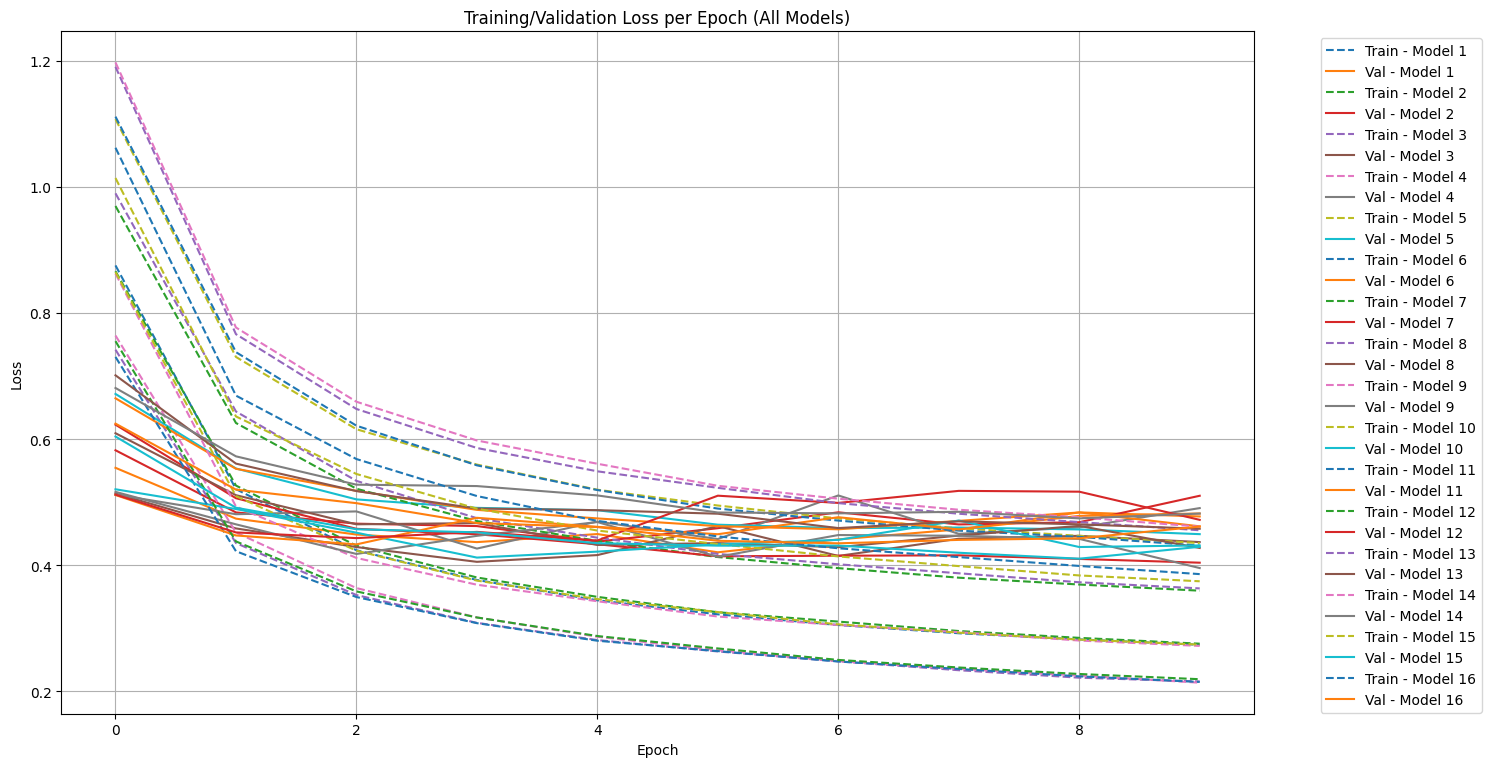

In [ ]:
plt.figure(figsize=(15,8))
for res in results:
    plt.plot(res['train_losses'], label=f"Train - Model {res['model_id']}", linestyle='--')
    plt.plot(res['val_losses'], label=f"Val - Model {res['model_id']}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training/Validation Loss per Epoch (All Models)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
best_model = POSCNNModel(
    vocab_size=len(word2idx),
    embed_dim=100,
    output_dim=len(tag2idx),
    embedding_matrix=embedding_matrix,
    filter_sizes=best_config['filter_sizes'],
    num_filters=best_config['num_filters'],
    num_stacked_layers=best_config['num_stacked_layers'],
    dropout_rate=best_config['dropout_rate'],
    pad_idx=word2idx["<PAD>"],
    freeze_embeddings=True
).to(device)

best_model.load_state_dict(best_model_state)

<All keys matched successfully>

In [ ]:
def evaluate_pos_model_with_auc(model, data_loader, idx2tag, ignore_index=-100):
    model.eval()
    device = next(model.parameters()).device

    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for X_batch, y_batch, lengths in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)  # (batch_size, seq_len, num_classes)
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(probs, dim=-1)

            for pred_seq, true_seq, prob_seq, length in zip(preds, y_batch, probs, lengths):
                for p, t, prob in zip(pred_seq[:length], true_seq[:length], prob_seq[:length]):
                    if t.item() == ignore_index:
                        continue  # skip padding
                    y_true.append(t.item())
                    y_pred.append(p.item())
                    y_probs.append(prob.cpu().numpy())

    y_probs = np.array(y_probs)
    num_classes = len(idx2tag)

    # Basic scores
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[idx2tag[i] for i in range(num_classes)]))

    # AUC
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    pr_auc = {}
    auc_sum = 0
    valid_classes = 0

    for i in range(num_classes):
        if np.sum(y_true_bin[:, i]) == 0:
            continue  # skip classes not present in ground truth
        precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        score = auc(recall_vals, precision_vals)
        tag_name = idx2tag[i]
        pr_auc[tag_name] = score
        auc_sum += score
        valid_classes += 1

    macro_auc = auc_sum / valid_classes if valid_classes > 0 else 0

    print("\n📈 Precision-Recall AUC per tag:")
    for tag, score in pr_auc.items():
        print(f"{tag:>6}: {score:.4f}")

    print(f"\n🔹 Macro-averaged PR AUC: {macro_auc:.4f}")


In [ ]:
print("\n--- Train Set ---")
evaluate_pos_model_with_auc(best_model, train_loader, idx2tag)

print("\n--- Dev Set ---")
evaluate_pos_model_with_auc(best_model, dev_loader, idx2tag)

print("\n--- Test Set ---")
evaluate_pos_model_with_auc(best_model, test_loader, idx2tag)



--- Train Set ---

📊 Classification Report:
              precision    recall  f1-score   support

       PROPN       0.88      0.87      0.88     12924
       PUNCT       0.99      0.99      0.99     23676
         ADJ       0.91      0.91      0.91     12459
        NOUN       0.93      0.94      0.94     34786
        VERB       0.96      0.94      0.95     23028
         DET       0.99      0.99      0.99     16284
         ADP       0.95      0.97      0.96     17625
         AUX       0.96      0.99      0.98     12396
        PRON       0.99      0.99      0.99     18584
        PART       0.96      0.99      0.97      5567
       SCONJ       0.88      0.90      0.89      4502
         NUM       0.96      0.97      0.96      3996
         ADV       0.90      0.88      0.89      9903
       CCONJ       0.99      0.99      0.99      6703
           _       0.97      1.00      0.98      2444
           X       0.69      0.56      0.62       845
        INTJ       0.90      0.83   

## Baseline

In [ ]:
# word_to_tag_counter: {"cat": {"NOUN": 12, "VERB": 1}, ...}
# most_frequent_tag: the most common POS tag overall
def build_baseline_dict_numeric(sequences):
    word_tag_counts = defaultdict(Counter)
    tag_counts = Counter()

    for tokens, tag_ids in sequences:
        for word, tag in zip(tokens, tag_ids):
            word_tag_counts[word.lower()][tag] += 1
            tag_counts[tag] += 1

    most_frequent_tag = tag_counts.most_common(1)[0][0]
    word_to_best_tag = {word: tag_counter.most_common(1)[0][0] for word, tag_counter in word_tag_counts.items()}
    return word_to_best_tag, most_frequent_tag


In [ ]:
def evaluate_baseline_numeric(sequences, word_to_best_tag, most_frequent_tag):
    y_true, y_pred = [], []
    for tokens, tag_ids in sequences:
        for word, true_tag in zip(tokens, tag_ids):
            predicted_tag = word_to_best_tag.get(word.lower(), most_frequent_tag)
            y_true.append(true_tag)
            y_pred.append(predicted_tag)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print("\n🔹 Baseline Evaluation:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    return accuracy, precision, recall, f1


In [ ]:
# Baseline
word_to_best_tag, most_frequent_tag = build_baseline_dict_numeric(train_seqs)

dev = evaluate_baseline_numeric(dev_seqs, word_to_best_tag, most_frequent_tag)
test = evaluate_baseline_numeric(test_seqs, word_to_best_tag, most_frequent_tag)


🔹 Baseline Evaluation:
Accuracy:  0.8520
Precision: 0.8618
Recall:    0.7620
F1 Score:  0.7889

🔹 Baseline Evaluation:
Accuracy:  0.8542
Precision: 0.8627
Recall:    0.7741
F1 Score:  0.7950


## Most frequent tag for unknown words

In [ ]:
int2tag = train_data.features["upos"].feature.int2str

In [ ]:
# print("Most frequent tag overall (ID):", most_frequent_tag)
print("Most frequent tag overall (label):", int2tag(most_frequent_tag))

Most frequent tag overall (label): NOUN


In [ ]:
word = "is"
tag_id = word_to_best_tag.get(word.lower(), most_frequent_tag)
print(f'Most frequent tag for "{word}": {int2tag(tag_id)}')

Most frequent tag for "is": AUX


In [ ]:
word = ":"
tag_id = word_to_best_tag.get(word.lower(), most_frequent_tag)
print(f'Most frequent tag for "{word}": {int2tag(tag_id)}')

Most frequent tag for ":": PUNCT


In [ ]:
print("flerb" in word2idx)

False


In [ ]:
word = "flerb"
tag_id = word_to_best_tag.get(word.lower(), most_frequent_tag)
print(f'Most frequent tag for "{word}": {int2tag(tag_id)}')

Most frequent tag for "flerb": NOUN
